# Introduction

This notebook is an identical copy of the notebook that we worked through in our submission for Homework on Multi-Agent Systems during AI Engineering Cohort #4 Week 3 day 2 Assignment!!!!

> DIFFERENCE - The document I use to build the multi-agent RAG pipeline in this notebook is the "Attention Is All you need" paper (https://arxiv.org/pdf/1706.03762) instead of what we used for the assignment in class.

## EXAMPLE APPLICATION - Uses the Attention is all you need paper!!!!

# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!

> NOTE: We'll be following along with the official LangGraph implementation very closely, which you can find [here](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb), with some minor modifications and extensions to showcase just how straightforward it is to modify LangGraph implementations to suit your own needs!



## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [1]:
## Using Chris Aleiuk's suggestion to avoid notebook crashes later on...
# !pip uninstall -y langchain-experimental
!pip install -qU langgraph==0.2.14 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.35 langchain-community==0.2.12


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Commenting out code from original notebook
# !pip install -qU langgraph langchain langchain_openai langchain_experimental

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [2]:
!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [4]:
from langchain.document_loaders import PyMuPDFLoader

# attention is all you need paper:  https://arxiv.org/pdf/1706.03762

# Extending LlaMA-3 context window 10-fold overnight paper: https://arxiv.org/pdf/2404.19553

docs = PyMuPDFLoader("https://arxiv.org/pdf/1706.03762").load()


In [5]:
docs

[Document(metadata={'source': 'https://arxiv.org/pdf/1706.03762', 'file_path': 'https://arxiv.org/pdf/1706.03762', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240410211143Z', 'modDate': 'D:20240410211143Z', 'trapped': ''}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.c

In [6]:
len(docs)

15

Now we can chunk it down to size!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

Now we've successfully split our single PDF into...

In [8]:
len(split_chunks)

43

In [9]:
split_chunks[0:2]

[Document(metadata={'source': 'https://arxiv.org/pdf/1706.03762', 'file_path': 'https://arxiv.org/pdf/1706.03762', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240410211143Z', 'modDate': 'D:20240410211143Z', 'trapped': ''}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.c

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [10]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [11]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [12]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [14]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [15]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [16]:
# rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

rag_chain.invoke({"question" : "What is a transformer?"})

'A transformer is a model architecture that relies entirely on an attention mechanism to draw global dependencies between input and output, eschewing recurrence. It allows for significantly more parallelization in processing and can achieve state-of-the-art performance in tasks such as translation after relatively short training times. The architecture consists of an encoder-decoder structure, where the encoder maps an input sequence to continuous representations, and the decoder generates an output sequence in an auto-regressive manner. The transformer employs stacked self-attention and fully connected layers, with both the encoder and decoder featuring multiple identical layers and residual connections to facilitate effective learning.'

In [17]:
rag_chain.invoke({"question" : "What is attention?"})

'Attention is a mechanism used in neural networks, particularly in natural language processing, to determine the relevance of different words or tokens in a sequence when processing an input. It allows the model to focus on specific parts of the input when generating an output, effectively weighing the importance of different inputs depending on the context.\n\nIn the context provided, attention is described in terms of "Scaled Dot-Product Attention," where the input consists of queries and keys of dimension \\(d_k\\), and values of dimension \\(d_v\\). The mechanism computes the dot products of the query with all keys, scales these values, and applies a softmax function to obtain weights for the corresponding values. The output is then computed as a weighted sum based on these weights. \n\nAdditionally, attention can also be categorized into multi-head attention, where several attention layers operate in parallel, enhancing the model\'s ability to capture different types of relationsh

In [18]:
rag_chain.invoke({"question" : "What is multi-headed attention?"})

'Multi-headed attention is a mechanism used in the Transformer model that allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function with dmodel-dimensional keys, values, and queries, multi-headed attention linearly projects the queries, keys, and values h times with different learned linear projections to dk, dk, and dv dimensions, respectively. The attention function is then performed in parallel on these projected versions, yielding dv-dimensional output values. This approach allows the model to capture various aspects of the input data by utilizing multiple attention heads, which enhances its ability to focus on different parts of the input sequence simultaneously. \n\nThe formula for multi-head attention is given by:\n\\[ \\text{MultiHead}(Q, K, V) = \\text{Concat}(\\text{head}_1, \\ldots, \\text{head}_h) W_O \\]\nwhere each head is computed as:\n\\[ \\text{head}_i = \\text{Att

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

# NOTE - I Did not Run Activity #1 In this Exploration!!!
Activity #1 was run and submitted for the class assignment, though...

## ACTIVITY # 1: 
========================== BEGIN ACTIVITY # 1 =========================================================

### NOTES - PLEASE READ

### Steps to build system to dynamically retrieve Arxiv papers

1.   build an agent that can search on Arxiv and return the url(s) of one or more relevant papers

2.  loop over the list of of returned urls to do the following:
-   load them into a text string
-   chunk the doc
-   merge the chunks of all docs
-   load into vector store
-   set up retriever


3.  _I've set up the code needed to dynamically produce a URL in a separate python script `agentic_arxiv_paper_finder_loader.py`_

4.  Start by specifying a search string in the cell below the Imports cell.  The next cell will retrieve the URL.  The following cell will, if the URL is valid, load the pdf into text string, split the text into chunks, load into vector store and set up a retriever.


In [ ]:
# Imports
import re
import pprint

from langchain_core.messages import HumanMessage
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

In [ ]:
arxiv_search_string = 'Attention Is All You Need'

In [ ]:
# NOTE!!!!!!
# ALL THE CODE NEEDED IS IN A SEPARATE PYTHON SCRIPT that is imported here
from agentic_arxiv_paper_finder_loader import get_arxiv_paper_url

# user prompt format
user_prompt_format = """\
    What is the url of the pdf version of the paper on {search_string} on Arxiv?
    Please return only URL of the paper in JSON format.\
"""

# set up user prompt using search string and user prompt format
user_prompt = user_prompt_format.format(search_string=arxiv_search_string)

# set up inputs to agent
inputs = {
    "messages" : [HumanMessage(content=user_prompt)]
}

# run code to get url for paper on the topic of the `arxiv_search_string`
response, url = \
    get_arxiv_paper_url(tools=[ArxivQueryRun()],
                        user_message=inputs)

# Ideally I would parse the output using Langchain's JSONOutputParser()
# Left for another day -here I use regex based extraction

# select out the string corresponding to url - 
# Needed because the regex extracts extra double quotes at start and end of url string
url = url[1:-1]

# Verify the sequence of messages from agent
pprint.pprint(response)

# print url!!
print(url)

In [ ]:
if url is not None:
    try:
        newdocs = PyMuPDFLoader(url).load()
    except Exception as e2:
        raise
    
    new_split_chunks = text_splitter.split_documents(newdocs)

    # remove spaces and concatenate search string using underscore - to pass in as collection name
    collection_name_for_vectorstore = '_'.join(arxiv_search_string.split())
    
    new_qdrant_vectorstore = Qdrant.from_documents(
        new_split_chunks,
        embedding_model,
        location=":memory:",
        collection_name=collection_name_for_vectorstore,
    )

    new_qdrant_retriever = new_qdrant_vectorstore.as_retriever()

    new_rag_chain = (
        {"context": itemgetter("question") | new_qdrant_retriever, "question": itemgetter("question")}
        | rag_prompt | openai_chat_model | StrOutputParser()
    )

    new_rag_chain.invoke({"question" : f"What is multi-headed attention?"})

=========================== END ACTIVITY #1 =======================================================

## Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [19]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [20]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [21]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [22]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [24]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
  return rag_chain.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [25]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4-turbo` today. This LLM is going to be doing a lot of reasoning - and so using a "powerful" LLM is very important here!

In [26]:
llm = ChatOpenAI(model="gpt-4-turbo")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

## ANSWER #1:

A powerful LLM is important for this use case because the Supervisor LLM needs to be able to reason on nuanced questions such as 'is the task FINISHED at the team level?' or 'should I bring in a new agent with specific capabilities to enhance the work that's already been done?' or 'should I ask the currently active agent to further refine the result?', etc.  These are higher-level reasoning tasks.

Potentially the Supervisor Agent will have to read and the understand the entire history of messages from all the team-level agents and be able to distill down the content to key questions as listed above.  Less powerful LLMs are known to be distracted, hallucinate or otherwise just unable to complete the reasoning ability that may be needed for success in multi-agent settings.

The best analogy I can think of - on human-led teams, it will be important for the supervisor to understand the outputs of tasks performed by team members at various levels of detail.  In particular, though, in order to dynamically manage the team's agenda, the supervisor needs to be able to distill down the vast amount of information and assign/refine tasks to team members, with knowledge of their strengths and capabilities, etc.  The supervisor needs to play at the level of the team member if needed, but to also raise their game to look across the team when needed...

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4 Turbo model, and then create its node - and name it `Search`.

In [27]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [28]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'. You must only respond with information about the paper related to the request.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [29]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [30]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [31]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [32]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

#### Display Graph

In [33]:
!pip install -qU python_mermaid


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


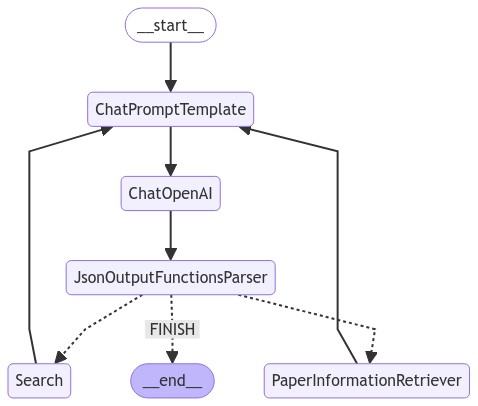

In [34]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [35]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | chain

Now, finally, we can take it for a spin!

In [36]:
for s in research_chain.stream(
    "What are the main takeaways from the paper `Attention is all you need? Please use Search and PaperInformationRetriever!", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='The main takeaways from the paper "Attention is All You Need" are:\n\n1. **Introduction of the Transformer Architecture**: The paper introduced a new neural network model called the Transformer, which has had a significant impact on the field of Natural Language Processing (NLP).\n\n2. **Elimination of Recurrent Layers**: Unlike traditional models that relied on recurrent or convolutional layers, the Transformer uses self-attention mechanisms to process data in parallel and capture complex relationships in data.\n\n3. **Improved Performance in NLP Tasks**: The Transformer model demonstrated state-of-the-art performance in several NLP tasks, particularly in machine translation. It outperformed existing models on the WMT 2014 English-to-German and English-to-French translation tasks.\n\n4. **Efficiency and Scalability**: Due to its ability to process data in parallel, the Transformer model is more effic

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

## ACTIVITY #2 BELOW

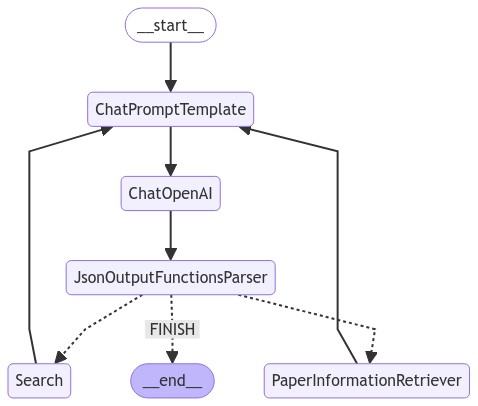

In [37]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

## ANSWER #2:

We can ensure that the Agent uses specific tools by binding the LLM to the tool set that you'd like it to use for that agent workflow.  e.g., a search agent can only be given access to a search tool but not a RAG retriever tool; or conversely, give a researcher agent access to the RAG retriever tool but not to an open-ended search tool.

If it is desired to concretely set a flow through tools, then we can do it by incorporating this logic into the agent.  e.g., examine the response object and if there is no tool call, then iterate inside the agent in a loop until there is a tool call (obviously this has the potential to run forever, so you'd also want to put in additional criteria to prevent a large number of loops without a toolcall in this case).


## Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [38]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

## What These Tools Are Doing:

1.  `create_random_subdirectory`: This generates a random alphanumeric string of 8 characters using UUID and creates a sub-directory with that name under the specified path (i specify the path as ./content/data).

2.  `create_outline`: for each element in a list that contains the collection of outline points, this tool writes out a separate line in a file for that item along with a point-number starting with 1, 2, 3, ... etc.

2.  `read_document`: this tool reads a text file line by line into elements of a list named `lines`.  The elements of `lines` are then concatenated together into a string with line breaks `\n` in between them.

4.  `write_document`: this tool writes out text from a string object `content` into a file on disk.

5.  `edit_document`: this tool edits a file that has previously been saved to disk.  Here's how: first read in the file into a list (each line is a new element of the list).  Then, sort the lines to be inserted in ascending order of their line number.   The edits are 1-indexed.  So, carefully, paying attention to pythonic indexing which is 0-indexing, replace the content of the relevant lines with the new content.  Finally, write out the edited file back to disk.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [39]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [40]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [41]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [42]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()

#### Display Graph

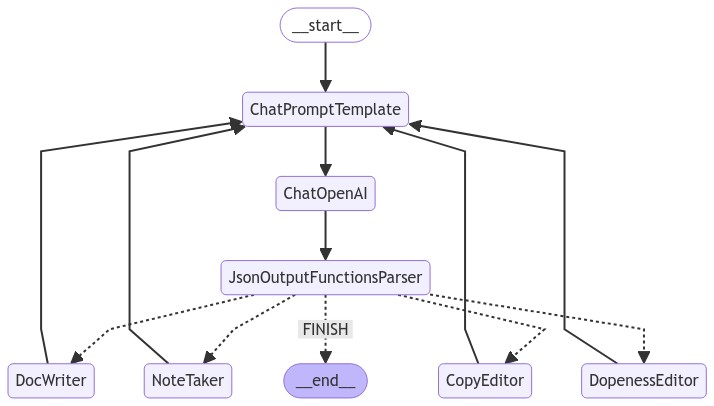

In [43]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [44]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [45]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully written and saved to disk as "LinkedIn_Post_Outline_Linear_Regression.txt".', name='DocWriter')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


## Meta-Supervisor

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [46]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [47]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [48]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [49]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [53]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Attention is all you need'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='### LinkedIn Post Draft on "Attention is All You Need" Paper\n\n🚀 Exciting Milestones in AI: A Look at the “Attention Is All You Need” Paper 🚀\n\nIn 2017, a groundbreaking paper titled "Attention Is All You Need" authored by Ashish Vaswani and his colleagues at Google revolutionized the field of machine learning. This pioneering work introduced the transformer architecture, leveraging an attention mechanism that allows models to focus on different parts of input data, which is crucial for tasks like language understanding.\n\nWhy is this important? 🤔 The transformer model is exceptionally efficient at handling large datasets and can be parallelized significantly better than previous models. This capability has paved the way for advanced NLP systems, including well-known models like BERT and GPT, which have set new standards in the industry for understanding and generating human-like text

## What My Agents Created!!!!!
copied here from the file `Revised_LinkedIn_Post.txt`

🚀 **Revolution in AI: Unpacking the "Attention Is All You Need" Paper** 🚀

In 2017, a landmark paper by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin, titled "Attention Is All You Need," redefined the landscape of machine learning. This paper, crafted by a brilliant team at Google, introduced the now-famous transformer architecture, utilizing a novel attention mechanism.

**What makes it groundbreaking?** Unlike previous models that processed data sequentially, the transformer architecture allows for simultaneous processing, making it extraordinarily efficient at handling large datasets. This has been crucial for developing more sophisticated language models like BERT and GPT, dramatically enhancing the quality of machine-generated text.

**Impact on Tech and Beyond**: The implications of this research are vast, touching everything from automated translation services to advanced chatbots, and opening new avenues in AI research.

**Dive Deeper**: The attention mechanism assigns weighted importance to different words, allowing the model to focus more where it matters most, thus mimicking a more human-like understanding of language.

🔗 **Join the Conversation**: Have you worked with transformer-based models? Tell us your story and share how this architecture is shaping the future of AI.

#AI #MachineLearning #NLP #Innovation #Technology #DataScience #Google

**Visuals**: [Ensure to include the graphic of the Transformer model here]